device:  mps
Training network for time t_1 = 0.100 ...
  Epoch 200, Loss = 1.34287e-04
  Epoch 400, Loss = 1.71477e-04
  Epoch 600, Loss = 1.58495e-04
  Epoch 800, Loss = 1.09364e-04
  Epoch 1000, Loss = 1.36066e-04
Training network for time t_2 = 0.200 ...
  Epoch 200, Loss = 7.68078e-05
  Epoch 400, Loss = 6.13398e-05
  Epoch 600, Loss = 6.01183e-05
  Epoch 800, Loss = 6.94148e-05
  Epoch 1000, Loss = 7.06985e-05
Training network for time t_3 = 0.300 ...
  Epoch 200, Loss = 6.37454e-05
  Epoch 400, Loss = 3.36945e-05
  Epoch 600, Loss = 3.52889e-05
  Epoch 800, Loss = 3.02823e-05
  Epoch 1000, Loss = 2.70680e-05
Training network for time t_4 = 0.400 ...
  Epoch 200, Loss = 2.03053e-05
  Epoch 400, Loss = 1.98607e-05
  Epoch 600, Loss = 1.53626e-05
  Epoch 800, Loss = 1.62474e-05
  Epoch 1000, Loss = 2.29396e-05
Training network for time t_5 = 0.500 ...
  Epoch 200, Loss = 1.19631e-05
  Epoch 400, Loss = 9.20606e-06
  Epoch 600, Loss = 1.02827e-05
  Epoch 800, Loss = 6.66362e-06
  Epo

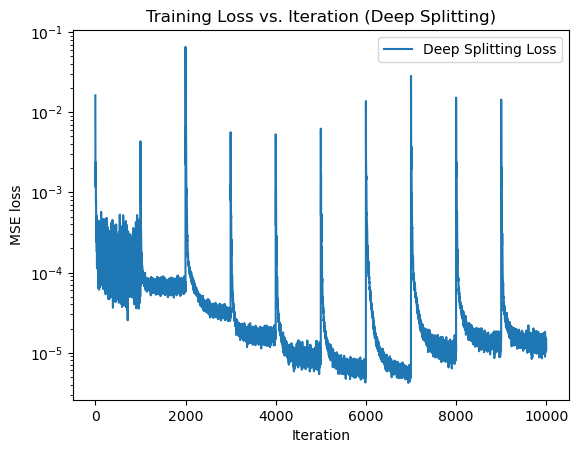

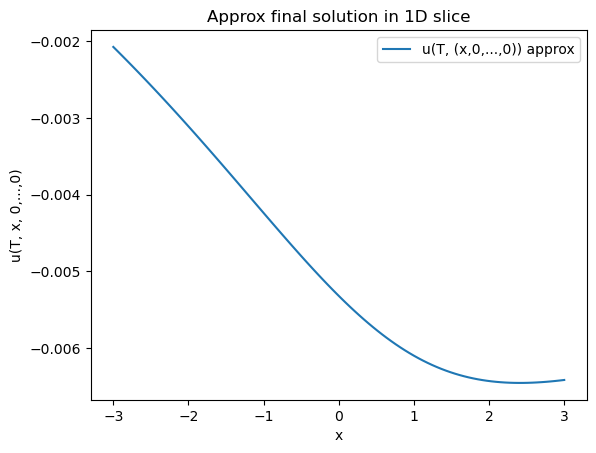

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

#======================================================================
#                    Device configuration
#======================================================================

# Device to use for computation
device = None

if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
    
    # Set CPU as the device for doing the computation
    device = torch.device("cpu")
else:
    # Set MPS(Metal programming framework) as the device for doing the computation
    device = torch.device("mps")
print("device: ", device)
#======================================================================
#======================================================================

#-------------------------------------------------
#            1. Hyperparameters
#-------------------------------------------------
pde_dimension = 10   # dimension of x
alpha         = 1.0  # fractional exponent
T             = 1.0  # final time
N_time_steps  = 10   # number of time splits
batch_size    = 1024 # batch size for Monte Carlo
lr_per_step   = 1e-3 # learning rate for each step
epochs_per_step = 1000  # how many epochs to train each time-step network
hidden_width  = 64   # width of hidden layers

#-------------------------------------------------
#   2. Generate alpha-stable increments in 10D
#      (For alpha=1, we do Cauchy(0, dt^(1/alpha)).
#      For alpha=2, standard normal with scale sqrt(dt).
#      You can generalize as needed.)
#-------------------------------------------------
def sample_alpha_stable(batch_size, dim, alpha, dt, device):
    """
    Return shape (batch_size, dim) of i.i.d. alpha-stable increments
    with 'time step' dt.  For demonstration, we implement:
       alpha=2.0 -> Gaussian with variance = 2 * dt   (symmetric stable)
       alpha=1.0 -> Cauchy(0, dt)
    """
    if alpha == 2.0:
        # Symmetric alpha-stable with alpha=2 is just Brownian motion,
        # so increments ~ Normal(0, sqrt(2*dt)).
        # If you want precisely "(-Delta)^(alpha/2)", you may need a
        # factor.  We'll do scale = sqrt(2 * dt) for demonstration.
        scale = (2.0 * dt)**0.5
        return scale * torch.randn(batch_size, dim, device=device)
    elif alpha == 1.0:
        # Symmetric Cauchy(0, scale=dt).  PyTorch has no built-in Cauchy
        # prior to 1.13, but we can do it via the StudentT with 1 degree
        # of freedom or define our own. For simplicity:
        dist = torch.distributions.cauchy.Cauchy(loc=0.0, scale=dt)
        return dist.sample((batch_size, dim)).to(device)
    else:
        raise NotImplementedError("sample_alpha_stable only handles alpha=1 or alpha=2 here.")

#-------------------------------------------------
# 3. Initial Condition
#    u(0,x) = exp( -||x||^2 )
#-------------------------------------------------
def initial_condition(x):
    # x shape = (batch_size, pde_dimension)
    return torch.exp(- torch.sum(x**2, dim=1, keepdim=True))

#-------------------------------------------------
# 4. Neural Nets
#   We'll store N+1 networks: net[0]..net[N].
#   net[0] is just the known initial condition (can code as a function),
#   or we can store it as a "frozen" neural net if we want.
#-------------------------------------------------
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)

# We create a Python list of length N+1.  net[0] is not a real net
# but a Python function for the init cond.  net[1..N] are trainable nets.
nets = [None]*(N_time_steps+1)

# net[0]: the exact init condition, stored as a Python lambda for convenience.
# In other contexts, you could store a "frozen" NN that you never train.
nets[0] = initial_condition

# net[k]: MLP for u(t_k, x)
for k in range(1, N_time_steps+1):
    nets[k] = MLP(input_dim=pde_dimension, hidden_dim=hidden_width).to(device)

#-------------------------------------------------
# 5. Training Loop for Deep Splitting
#    We do time steps k = 0..N-1, to get net[k+1].
#    At each step, net[k+1](x) ~ E[ net[k](x + Y) ].
#-------------------------------------------------
time_grid = np.linspace(0, T, N_time_steps+1)  # e.g. 0,0.1,...,1.0
dt = float(T / N_time_steps)

# We'll keep track of losses for visualization
training_losses = []

for k in range(N_time_steps):
    print(f"Training network for time t_{k+1} = {time_grid[k+1]:.3f} ...")
    optimizer = torch.optim.Adam(nets[k+1].parameters(), lr=lr_per_step)

    for epoch in range(epochs_per_step):
        optimizer.zero_grad()

        # 1) sample x ~ Normal(0,1) for 10D (or another distribution)
        x_batch = torch.randn(batch_size, pde_dimension, device=device)

        # 2) sample M alpha-stable increments (e.g. just 1 per x in this code).
        #    Alternatively, you can average multiple increments to reduce variance.
        Y = sample_alpha_stable(batch_size, pde_dimension, alpha, dt, device)

        # 3) Evaluate the "previous" net at x+Y
        #    net[k] might be a function (k=0) or an MLP (k>0).
        if k == 0:
            # net[0] is the known initial condition function
            u_prev = nets[k](x_batch + Y)  # call initial_condition
        else:
            u_prev = nets[k](x_batch + Y)

        # 4) We want net[k+1](x) \approx E[u_prev].  Here we do it with 1 sample
        #    per x. If you want a better Monte Carlo estimate, you can sample M>1
        #    increments per x and average.  We'll keep it simple.
        u_target = u_prev.detach()  # we treat the previous net's value as "target"

        # Evaluate the new net
        u_new = nets[k+1](x_batch)

        # 5) MSE loss
        loss = torch.mean((u_new - u_target)**2)
        loss.backward()
        optimizer.step()

        training_losses.append(loss.item())

        if (epoch+1) % 200 == 0:
            print(f"  Epoch {epoch+1}, Loss = {loss.item():.5e}")

print("Deep Splitting training complete.")

#-------------------------------------------------
# 6. The final network nets[N_time_steps] approximates u(T,x).
#    If you want the solution at some 0 < t < T, you can use
#    nets[k] for whichever step is closest.
#-------------------------------------------------

# Plot the loss curve
plt.figure()
plt.plot(training_losses, label="Deep Splitting Loss")
plt.xlabel("Iteration")
plt.ylabel("MSE loss")
plt.yscale("log")
plt.title("Training Loss vs. Iteration (Deep Splitting)")
plt.legend()
plt.show()

#-------------------------------------------------
# Quick Check:  Compare final net to exact solution
# at time T in some small 1D slice, if alpha=2 (for instance)
# or just see if it decays as expected.  There's no closed form
# for alpha=1 except through integral representations, so
# we'll just illustrate that the network yields a "reasonable" shape.
#-------------------------------------------------
def evaluate_final_net_1d_slice(x_vals_1d):
    """
    Evaluate the final net at x = (x1, 0,0,...,0).
    We'll see if it decays with |x|.
    """
    # net[T] is nets[N_time_steps]
    # We'll do an explicit CPU evaluation for plotting
    x_tensor = torch.zeros((len(x_vals_1d), pde_dimension))
    x_tensor[:,0] = torch.tensor(x_vals_1d)
    x_tensor = x_tensor.to(device)

    with torch.no_grad():
        u_approx = nets[N_time_steps](x_tensor).cpu().numpy().ravel()
    return u_approx

x_range = np.linspace(-3, 3, 100)
u_plot = evaluate_final_net_1d_slice(x_range)

plt.figure()
plt.plot(x_range, u_plot, label="u(T, (x,0,...,0)) approx")
plt.title("Approx final solution in 1D slice")
plt.xlabel("x")
plt.ylabel("u(T, x, 0,...,0)")
plt.legend()
plt.show()


device:  mps
Training network for time t_1 = 0.100 ...
  Epoch 200, Loss = 4.14330e-04
  Epoch 400, Loss = 1.15974e-04
  Epoch 600, Loss = 7.07182e-05
  Epoch 800, Loss = 4.09718e-05
  Epoch 1000, Loss = 2.77364e-04
Training network for time t_2 = 0.200 ...
  Epoch 200, Loss = 7.85236e-05
  Epoch 400, Loss = 7.27222e-05
  Epoch 600, Loss = 7.96460e-05
  Epoch 800, Loss = 7.79092e-05
  Epoch 1000, Loss = 9.57336e-05
Training network for time t_3 = 0.300 ...
  Epoch 200, Loss = 3.64182e-05
  Epoch 400, Loss = 3.63026e-05
  Epoch 600, Loss = 3.88880e-05
  Epoch 800, Loss = 3.36819e-05
  Epoch 1000, Loss = 3.58548e-05
Training network for time t_4 = 0.400 ...
  Epoch 200, Loss = 2.52462e-05
  Epoch 400, Loss = 1.86029e-05
  Epoch 600, Loss = 1.62399e-05
  Epoch 800, Loss = 1.60281e-05
  Epoch 1000, Loss = 1.70902e-05
Training network for time t_5 = 0.500 ...
  Epoch 200, Loss = 3.35225e-05
  Epoch 400, Loss = 1.63591e-05
  Epoch 600, Loss = 1.48402e-05
  Epoch 800, Loss = 1.43629e-05
  Epo

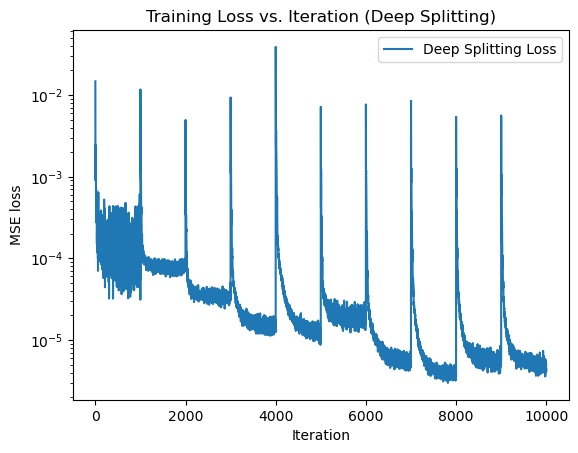

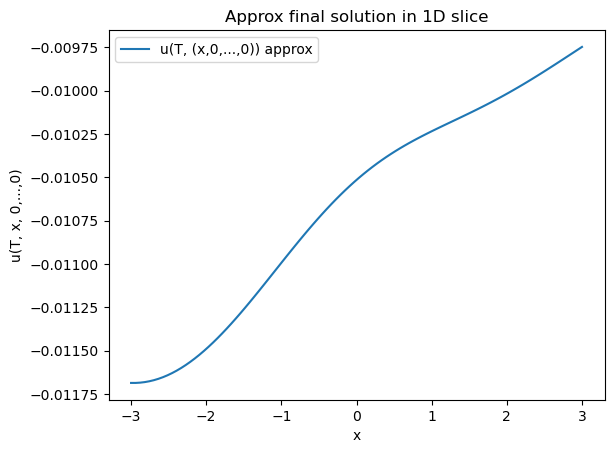

Done! Saved predictions in predictions.json


In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import math

#======================================================================
#                    Device configuration
#======================================================================

# Device to use for computation
device = None

if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
    
    # Set CPU as the device for doing the computation
    device = torch.device("cpu")
else:
    # Set MPS(Metal programming framework) as the device for doing the computation
    device = torch.device("mps")
print("device: ", device)

#-------------------------------------------------
#            1. Hyperparameters
#-------------------------------------------------
pde_dimension = 10   # dimension of x
alpha         = 1.0  # fractional exponent
T             = 1.0  # final time
N_time_steps  = 10   # number of time splits
batch_size    = 1024 # batch size for Monte Carlo
lr_per_step   = 1e-3 # learning rate for each step
epochs_per_step = 1000  # how many epochs to train each time-step network
hidden_width  = 64   # width of hidden layers

#-------------------------------------------------
#   2. Generate alpha-stable increments in 10D
#-------------------------------------------------
def sample_alpha_stable(batch_size, dim, alpha, dt, device):
    """
    Return shape (batch_size, dim) of i.i.d. alpha-stable increments
    with 'time step' dt.
    - alpha=2.0 -> Gaussian with variance=2*dt (symmetric stable).
    - alpha=1.0 -> Cauchy(0, dt) using inverse transform (because MPS
                   does not implement cauchy_.)
    """
    if alpha == 2.0:
        scale = (2.0 * dt)**0.5
        return scale * torch.randn(batch_size, dim, device=device, dtype=torch.float32)
    elif alpha == 1.0:
        # Cauchy(0, dt) = dt * tan(pi*(U-0.5)), U ~ Uniform(0,1)
        U = torch.rand((batch_size, dim), device=device, dtype=torch.float32)
        return dt * torch.tan(math.pi*(U - 0.5))
    else:
        raise NotImplementedError("sample_alpha_stable only handles alpha=1 or alpha=2 here.")

#-------------------------------------------------
# 3. Initial Condition
#    u(0,x) = exp( -||x||^2 )
#-------------------------------------------------
def initial_condition(x):
    # x shape = (batch_size, pde_dimension)
    return torch.exp(- torch.sum(x**2, dim=1, keepdim=True))

#-------------------------------------------------
# 4. Neural Nets
#-------------------------------------------------
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim, dtype=torch.float32),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim, dtype=torch.float32),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim, dtype=torch.float32),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim, dtype=torch.float32)
        )
    def forward(self, x):
        return self.net(x)

# We create a Python list of length N+1.  
# net[0] is the known initial condition function
# net[1..N] are trainable nets.
nets = [None]*(N_time_steps+1)
nets[0] = initial_condition  # not an nn.Module, just a Python function

for k in range(1, N_time_steps+1):
    nets[k] = MLP(input_dim=pde_dimension, hidden_dim=hidden_width).to(device)

#-------------------------------------------------
# 5. Training Loop for Deep Splitting
#-------------------------------------------------
time_grid = np.linspace(0, T, N_time_steps+1, dtype=np.float32)  # [0, 0.1, 0.2, ..., 1.0]
dt = float(T / N_time_steps)

training_losses = []

for k in range(N_time_steps):
    print(f"Training network for time t_{k+1} = {time_grid[k+1]:.3f} ...")
    optimizer = torch.optim.Adam(nets[k+1].parameters(), lr=lr_per_step)

    for epoch in range(epochs_per_step):
        optimizer.zero_grad()

        # 1) sample x ~ Normal(0,1) for 10D
        x_batch = torch.randn(batch_size, pde_dimension, device=device, dtype=torch.float32)

        # 2) sample alpha-stable increments
        Y = sample_alpha_stable(batch_size, pde_dimension, alpha, dt, device)

        # 3) Evaluate net[k] at x+Y
        if k == 0:
            u_prev = nets[k](x_batch + Y)  # call initial_condition
        else:
            u_prev = nets[k](x_batch + Y)

        # 4) target is E[u_prev], but here we have only 1 sample, so we treat
        #    it as the target directly.
        u_target = u_prev.detach()

        # 5) net[k+1](x) ~ u_target
        u_new = nets[k+1](x_batch)
        loss = torch.mean((u_new - u_target)**2)
        loss.backward()
        optimizer.step()

        training_losses.append(loss.item())

        if (epoch+1) % 200 == 0:
            print(f"  Epoch {epoch+1}, Loss = {loss.item():.5e}")

print("Deep Splitting training complete.")

#-------------------------------------------------
# 6. Plot the training loss
#-------------------------------------------------
plt.figure()
plt.plot(training_losses, label="Deep Splitting Loss")
plt.xlabel("Iteration")
plt.ylabel("MSE loss")
plt.yscale("log")
plt.title("Training Loss vs. Iteration (Deep Splitting)")
plt.legend()
plt.show()

#-------------------------------------------------
# 7. Evaluate final net in a 1D slice (optional sanity check)
#-------------------------------------------------
def evaluate_final_net_1d_slice(x_vals_1d):
    # ensure x_vals_1d is float32
    x_vals_1d = np.array(x_vals_1d, dtype=np.float32)
    x_tensor = torch.zeros((len(x_vals_1d), pde_dimension), device=device, dtype=torch.float32)
    # place x_vals_1d into the first coordinate
    x_tensor[:,0] = torch.tensor(x_vals_1d, device=device, dtype=torch.float32)

    with torch.no_grad():
        u_approx = nets[N_time_steps](x_tensor).cpu().numpy().ravel()
    return u_approx

x_range = np.linspace(-3, 3, 100, dtype=np.float32)
u_plot = evaluate_final_net_1d_slice(x_range)

plt.figure()
plt.plot(x_range, u_plot, label="u(T, (x,0,...,0)) approx")
plt.title("Approx final solution in 1D slice")
plt.xlabel("x")
plt.ylabel("u(T, x, 0,...,0)")
plt.legend()
plt.show()

#===============================================================
# 8. Function to load test dataset & compute approximate solutions
#===============================================================
def approximate_solution_for_test_data(nets, dt, filename_in="test_data.json", filename_out="predictions.json"):
    """
    Reads time (t) and spatial points (x) from 'test_data.json', 
    evaluates the approximate solution for each (t_i, x_i),
    and saves the results into 'predictions.json'.
    
    We assume:
    - 't' is a list of floats, shape (N,)
    - 'x' is a list of lists, shape (N, pde_dimension)
    
    The approximation uses nets[k], where k is the closest time index to t_i.
    """
    # Read test data
    with open(filename_in, "r") as f:
        test_data = json.load(f)
    t_list = np.array(test_data["t"], dtype=np.float32)   # shape (N,)
    x_list = np.array(test_data["x"], dtype=np.float32)   # shape (N, pde_dimension)

    # Prepare container for solutions
    solutions = np.zeros((len(t_list),), dtype=np.float32)

    # Evaluate net at the nearest time step
    # time_grid: 0, dt, 2dt, ... N_time_steps*dt
    # Index k ~ round(t_i / dt)
    for i in range(len(t_list)):
        # clamp to [0, N_time_steps]
        k = int(round(t_list[i] / dt))
        k = max(0, min(k, N_time_steps))

        # Convert x[i] to a batch of shape (1, pde_dimension)
        x_torch = torch.from_numpy(x_list[i]).unsqueeze(0).to(device)  # shape (1, 10)
        x_torch = x_torch.type(torch.float32)

        # Evaluate the net
        if k == 0:
            # net[0] is the initial_condition function
            with torch.no_grad():
                val = nets[0](x_torch)
        else:
            with torch.no_grad():
                val = nets[k](x_torch)

        # val shape: (1,1). Move to CPU, store in solutions
        solutions[i] = val.cpu().numpy().flatten()[0]

    # Save solutions to JSON
    out_dict = {"approx_solutions": solutions.tolist()}
    with open(filename_out, "w") as f:
        json.dump(out_dict, f, indent=2)

    return solutions

#===============================================================
# 9. Example usage (if running as a script)
#===============================================================
if __name__ == "__main__":
    # Evaluate and save the predictions using the trained nets
    preds = approximate_solution_for_test_data(
        nets=nets,
        dt=dt,
        filename_in="test_data.json",
        filename_out="predictions.json"
    )
    print("Done! Saved predictions in predictions.json")
